# Pre-run

## Pre-run: installs and exports

In [1]:
# Install TextBlob
!pip install textblob

In [2]:
from textblob import TextBlob
from textblob import download_corpora

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from scipy.stats import linregress, spearmanr

In [6]:
import requests
import pandas as pd
import numpy as np
import json

## Github pull data

In [7]:
# url = "https://github.com/NAIST-SE/DevGPT/raw/refs/heads/main/snapshot_20230727/20230727_200003_commit_sharings.json"

In [8]:
# https://github.com/NAIST-SE/DevGPT/raw/refs/heads/main/snapshot_20230727/20230727_200003_commit_sharings.json
repo = "https://github.com/NAIST-SE/DevGPT/raw/refs/heads/main/"
urls = [
    "snapshot_20230727/20230727_200003_commit_sharings.json",
    "snapshot_20230803/20230803_095317_commit_sharings.json",
    "snapshot_20230810/20230810_124807_commit_sharings.json",
    "snapshot_20230817/20230817_131244_commit_sharings.json",
    "snapshot_20230824/20230824_102435_commit_sharings.json",
    "snapshot_20230831/20230831_063412_commit_sharings.json",
    "snapshot_20230907/20230907_110036_commit_sharings.json",
    "snapshot_20230914/20230914_083202_commit_sharings.json",
    "snapshot_20231012/20231012_230826_commit_sharings.json",
]

In [9]:
file_name = "data.json"

def git_pull_data():
  #df = pd.DataFrame(columns=["Commit Message", "AuthorAt", "CommitAt", "Prompt", "Answer", "AccessDate"])
  rows = []
  for url in urls:
    response = requests.get(f"{repo}{url}")
    if response.status_code == 200:
      data = json.loads(response.content)
      for source in data.get("Sources", []):
        commit_messages = {"CommitMessage":source["Message"], "AuthorAt": source['AuthorAt'], 'CommitAt': source['CommitAt'], "Conversation": []}
        convrow = []
        for convo in source.get("ChatgptSharing", []):
          for con in convo.get("Conversations", []):
            row = {
                "Prompt": con["Prompt"],
                "Answer": con["Answer"]
            }
            convrow.append(row)
        if len(convrow) > 0:
          commit_messages["Conversation"] = convrow
        rows.append(commit_messages)
  return rows

In [10]:
commits = git_pull_data()

## Functions

In [11]:
# Define TextBlob-based sentiment analysis
def textblob_sentiment(texts):
    sentiments = []
    for text in texts:
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity  # Ranges from -1 (negative) to +1 (positive)
        if polarity > 0:
            sentiment = 'Positive'
        elif polarity < 0:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        sentiments.append({'text': text, 'polarity': polarity, 'sentiment': sentiment})
    return sentiments

In [12]:
def sentfunc(text):
  return textblob_sentiment([text])[0]

# Generate Datasets

In [13]:
sentimentlist = []
for entrydict in commits[:]:
#  for commit, q&a in zip(entry['Commit',,:
  commitsentiment = sentfunc(entrydict['CommitMessage'])#[0:10] # sentfunc(dicts['CommitMessage'])
  #print(f"Commit Message: {entrydict['CommitMessage']}")
  qaslist = []
  for qnadict in entrydict['Conversation']:
    qsentiment = sentfunc(qnadict['Prompt'])#[0:10]
    asentiment = sentfunc(qnadict['Answer'])#[0:10]
    qaslist.append([qsentiment,asentiment])
  sentimentlist.append([commitsentiment,qaslist])

In [14]:
commitsentiments = [entry[0]['polarity'] for entry in sentimentlist]
commitsentiments[:3]

[0.0, 0.0, 0.25]

In [15]:
promptsentiments = [[qnadict[0]['polarity'] for qnadict in entry[1]] for entry in sentimentlist]
promptsentiments[:2]

[[0.11321428571428571,
  0.04785714285714286,
  0.09659090909090909,
  0.0,
  0.0,
  0.16666666666666666,
  0.018383838383838353,
  0.0],
 [0.2128787878787879,
  -0.15,
  0.0,
  0.0,
  0.0909090909090909,
  0.04545454545454545,
  0.0,
  0.0,
  0.39,
  0.0,
  0.35,
  0.2333333333333333,
  0.0,
  -0.0642857142857143,
  0.0,
  0.0,
  0.0,
  0.0,
  0.25,
  0.3181818181818182]]

In [16]:
answersentiments = [[qnadict[1]['polarity'] for qnadict in entry[1]] for entry in sentimentlist]
answersentiments[:2]

[[0.0,
  0.2534090909090909,
  0.1340909090909091,
  0.19285714285714287,
  0.2008658008658009,
  0.030303030303030297,
  0.035,
  -0.08714285714285715],
 [0.11237373737373736,
  0.17272727272727273,
  0.11357864357864357,
  0.3866666666666666,
  0.09882154882154882,
  0.2785714285714286,
  0.1472222222222222,
  -0.08214285714285714,
  0.10392857142857141,
  -0.16666666666666666,
  0.024206349206349197,
  0.05,
  -0.022727272727272728,
  0.2388888888888889,
  0.23333333333333334,
  -0.006249999999999999,
  0.0,
  -0.008333333333333335,
  0.13999999999999999,
  -0.040559440559440565]]

# RQ1 Graphs

compare commit sentiment vs prompt sentiment vs response sentiment (scatter plot)

In [17]:
# Compute average prompt sentiments per commit
avg_prompt_sentiments = [
    np.mean(prompts) if prompts else 0 for prompts in promptsentiments
]

In [18]:
# Compute average answer sentiments per commit
avg_answer_sentiments = [
    np.mean(answers) if answers else 0 for answers in answersentiments
]

In [19]:
# Flatten the prompt and answer sentiments for detailed analysis
flattened_prompt_sentiments = []
flattened_answer_sentiments = []
associated_commit_sentiments = []

In [20]:
for i in range(len(commitsentiments)):
    prompts = promptsentiments[i]
    answers = answersentiments[i]
    commit_sentiment = commitsentiments[i]

    min_len = min(len(prompts), len(answers))

    flattened_prompt_sentiments.extend(prompts)
    flattened_answer_sentiments.extend(answers)
    associated_commit_sentiments.extend([commit_sentiment] * min_len)

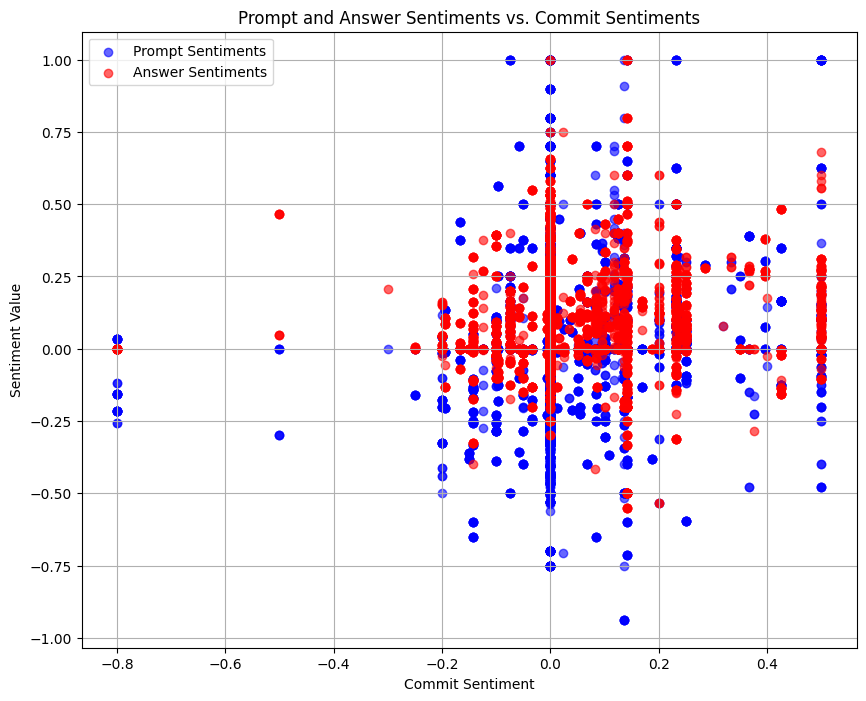

In [21]:
# Scatterplot: Prompt and Answer Sentiments vs. Commit Sentiments
plt.figure(figsize=(10, 8))

# Plot prompt sentiments
plt.scatter(
    associated_commit_sentiments,
    flattened_prompt_sentiments,
    color='blue',
    alpha=0.6,
    label='Prompt Sentiments'
)

# Plot answer sentiments
plt.scatter(
    associated_commit_sentiments,
    flattened_answer_sentiments,
    color='red',
    alpha=0.6,
    label='Answer Sentiments'
)

plt.xlabel('Commit Sentiment')
plt.ylabel('Sentiment Value')
plt.title('Prompt and Answer Sentiments vs. Commit Sentiments')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Convert lists to NumPy arrays for efficient computation
commit_sentiments = np.array(associated_commit_sentiments)
prompt_sentiments = np.array(flattened_prompt_sentiments)
answer_sentiments = np.array(flattened_answer_sentiments)

# Remove any NaN values if present (optional, depending on your data)
valid_prompt_mask = ~np.isnan(commit_sentiments) & ~np.isnan(prompt_sentiments)
valid_answer_mask = ~np.isnan(commit_sentiments) & ~np.isnan(answer_sentiments)

# Filter the data
commit_sentiments_for_prompts = commit_sentiments[valid_prompt_mask]
prompt_sentiments = prompt_sentiments[valid_prompt_mask]

commit_sentiments_for_answers = commit_sentiments[valid_answer_mask]
answer_sentiments = answer_sentiments[valid_answer_mask]

# 1. Perform Pearson correlation (for linear relationship)

# For prompts
prompt_pearson_corr_coef, prompt_pearson_p_value = linregress(commit_sentiments_for_prompts, prompt_sentiments)[:2]

# For answers
answer_pearson_corr_coef, answer_pearson_p_value = linregress(commit_sentiments_for_answers, answer_sentiments)[:2]

# 2. Perform Spearman rank correlation (for monotonic relationship)

# For prompts
prompt_spearman_corr_coef, prompt_spearman_p_value = spearmanr(commit_sentiments_for_prompts, prompt_sentiments)

# For answers
answer_spearman_corr_coef, answer_spearman_p_value = spearmanr(commit_sentiments_for_answers, answer_sentiments)

# 3. Print the results

print("Statistical Analysis of Commit Sentiments vs. Prompt Sentiments (for linear relationship):")
print(f"Pearson Correlation Coefficient: {prompt_pearson_corr_coef:.4f}, p-value: {prompt_pearson_p_value:.4e}")
print(f"Spearman Correlation Coefficient: {prompt_spearman_corr_coef:.4f}, p-value: {prompt_spearman_p_value:.4e}\n")

print("Statistical Analysis of Commit Sentiments vs. Answer Sentiments (for monotonic relationship):")
print(f"Pearson Correlation Coefficient: {answer_pearson_corr_coef:.4f}, p-value: {answer_pearson_p_value:.4e}")
print(f"Spearman Correlation Coefficient: {answer_spearman_corr_coef:.4f}, p-value: {answer_spearman_p_value:.4e}")

Statistical Analysis of Commit Sentiments vs. Prompt Sentiments (for linear relationship):
Pearson Correlation Coefficient: 0.2567, p-value: 1.9154e-02
Spearman Correlation Coefficient: 0.1383, p-value: 8.9556e-40

Statistical Analysis of Commit Sentiments vs. Answer Sentiments (for monotonic relationship):
Pearson Correlation Coefficient: 0.1139, p-value: 8.0952e-02
Spearman Correlation Coefficient: 0.1277, p-value: 4.1189e-34


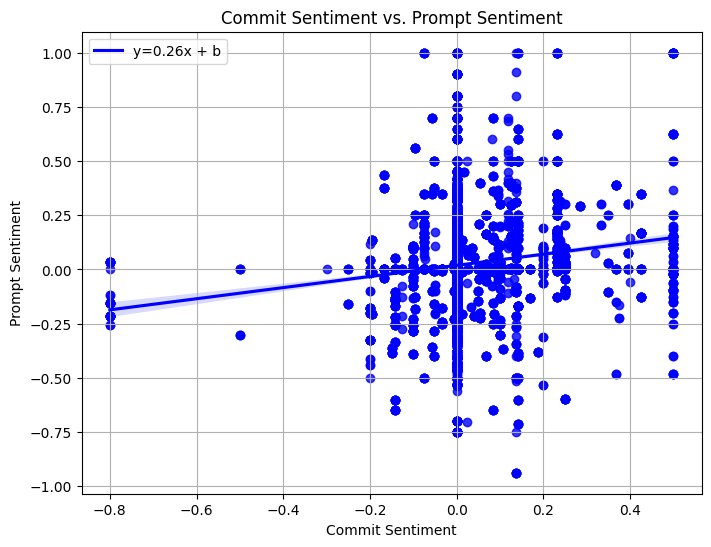

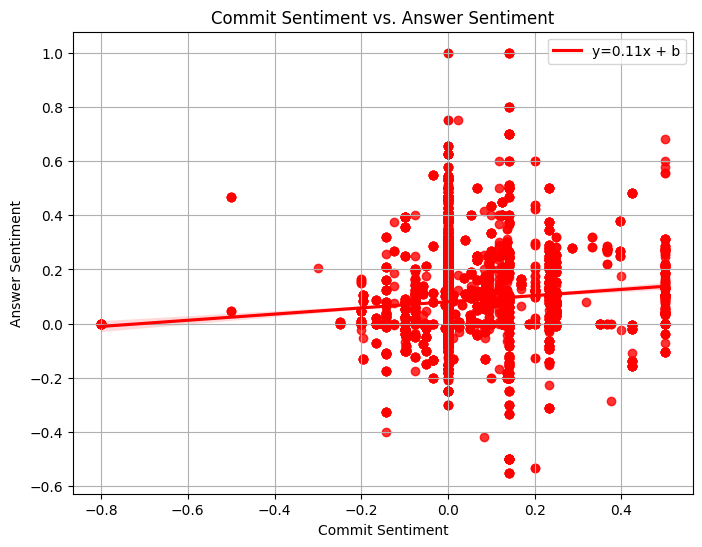

In [23]:
# For prompts
plt.figure(figsize=(8, 6))
sns.regplot(
    x=commit_sentiments_for_prompts,
    y=prompt_sentiments,
    color='blue',
    line_kws={'label': f"y={prompt_pearson_corr_coef:.2f}x + b"}
)
plt.xlabel('Commit Sentiment')
plt.ylabel('Prompt Sentiment')
plt.title('Commit Sentiment vs. Prompt Sentiment')
plt.legend()
plt.grid(True)
plt.show()

# For answers
plt.figure(figsize=(8, 6))
sns.regplot(
    x=commit_sentiments_for_answers,
    y=answer_sentiments,
    color='red',
    line_kws={'label': f"y={answer_pearson_corr_coef:.2f}x + b"}
)
plt.xlabel('Commit Sentiment')
plt.ylabel('Answer Sentiment')
plt.title('Commit Sentiment vs. Answer Sentiment')
plt.legend()
plt.grid(True)
plt.show()

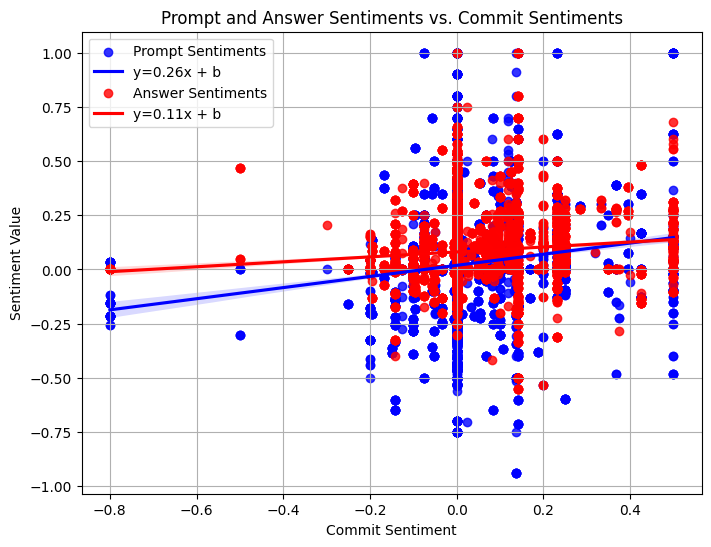

In [24]:
# Combine both above graphs into one

# For prompts
plt.figure(figsize=(8, 6))
sns.regplot(
    x=commit_sentiments_for_prompts,
    y=prompt_sentiments,
    color='blue',
    line_kws={'label': f"y={prompt_pearson_corr_coef:.2f}x + b"},
    label='Prompt Sentiments'
)

# For answers
sns.regplot(
    x=commit_sentiments_for_answers,
    y=answer_sentiments,
    color='red',
    line_kws={'label': f"y={answer_pearson_corr_coef:.2f}x + b"},
    label='Answer Sentiments'
)
plt.xlabel('Commit Sentiment')
plt.ylabel('Sentiment Value')
plt.title('Prompt and Answer Sentiments vs. Commit Sentiments')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Convert lists to NumPy arrays
commit_sentiments = np.array(associated_commit_sentiments)
prompt_sentiments = np.array(flattened_prompt_sentiments)
answer_sentiments = np.array(flattened_answer_sentiments)

# Remove any NaN values (if any)
valid_prompt_mask = ~np.isnan(commit_sentiments) & ~np.isnan(prompt_sentiments)
valid_answer_mask = ~np.isnan(commit_sentiments) & ~np.isnan(answer_sentiments)

# Filter the data
commit_sentiments_for_prompts = commit_sentiments[valid_prompt_mask]
prompt_sentiments = prompt_sentiments[valid_prompt_mask]

commit_sentiments_for_answers = commit_sentiments[valid_answer_mask]
answer_sentiments = answer_sentiments[valid_answer_mask]

### Duplicate code (done a slightly different way)

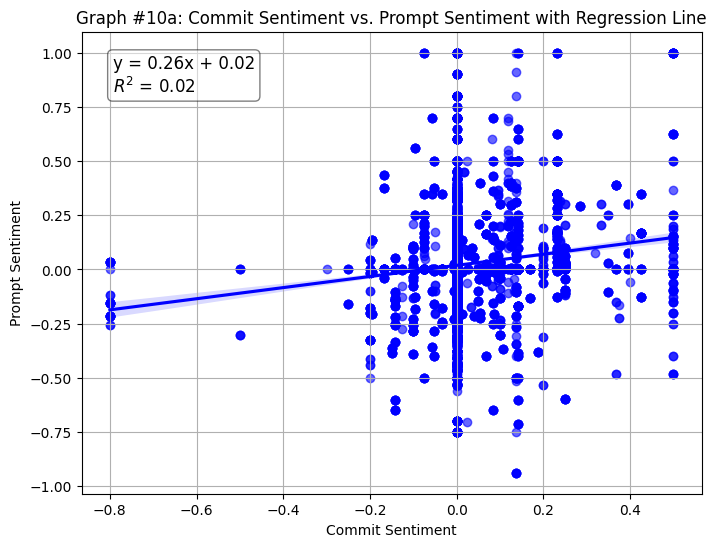

In [26]:
# Scatterplot with Regression Line for Prompts
# Compute regression statistics
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = linregress(commit_sentiments_for_prompts, prompt_sentiments)
line_eq_p = f'y = {slope_p:.2f}x + {intercept_p:.2f}\n$R^2$ = {r_value_p**2:.2f}'

plt.figure(figsize=(8, 6))
sns.regplot(
    x=commit_sentiments_for_prompts,
    y=prompt_sentiments,
    scatter_kws={'color': 'blue', 'alpha': 0.6},
    line_kws={'color': 'blue'}
)
plt.xlabel('Commit Sentiment')
plt.ylabel('Prompt Sentiment')
plt.title('Graph #10a: Commit Sentiment vs. Prompt Sentiment with Regression Line')
plt.text(
    0.05,
    0.95,
    line_eq_p,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)
plt.grid(True)
plt.show()


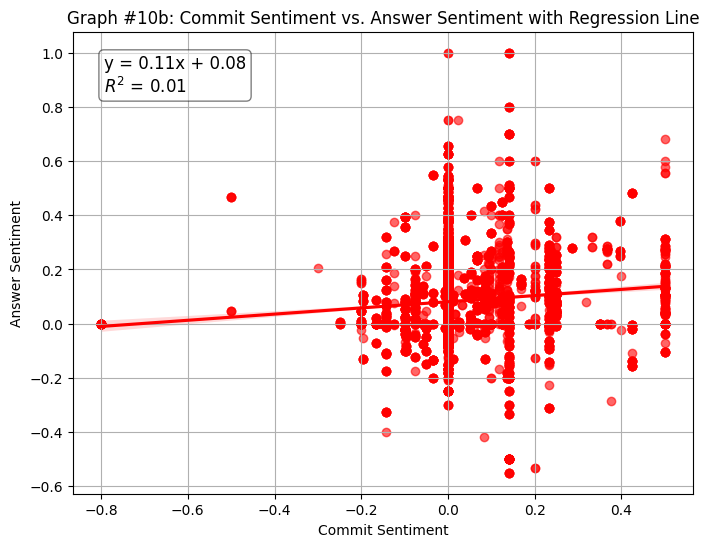

In [27]:
# Scatterplot with Regression Line for Answers
# Compute regression statistics
slope_a, intercept_a, r_value_a, p_value_a, std_err_a = linregress(commit_sentiments_for_answers, answer_sentiments)
line_eq_a = f'y = {slope_a:.2f}x + {intercept_a:.2f}\n$R^2$ = {r_value_a**2:.2f}'

plt.figure(figsize=(8, 6))
sns.regplot(
    x=commit_sentiments_for_answers,
    y=answer_sentiments,
    scatter_kws={'color': 'red', 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.xlabel('Commit Sentiment')
plt.ylabel('Answer Sentiment')
plt.title('Graph #10b: Commit Sentiment vs. Answer Sentiment with Regression Line')
plt.text(
    0.05,
    0.95,
    line_eq_a,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)
plt.grid(True)
plt.show()

# RQ2 Graphs

compare prompt sentiment vs response sentiment over multiple prompts (line chart? Averages?)

### Part 1: Sentiment Comparison

In [28]:
# 1. Data Preparation

# Lists to hold all prompts and answers with their turn numbers
all_prompt_sentiments = []
all_answer_sentiments = []
all_prompt_turns = []
all_answer_turns = []

max_turns = max(len(conv) for conv in promptsentiments + answersentiments)

for conv_idx in range(len(promptsentiments)):
    prompts = promptsentiments[conv_idx]
    answers = answersentiments[conv_idx]

    num_turns = min(len(prompts), len(answers))

    # Record prompt sentiments and their turn numbers
    all_prompt_sentiments.extend(prompts[:num_turns])
    all_prompt_turns.extend(range(1, num_turns + 1))

    # Record answer sentiments and their turn numbers
    all_answer_sentiments.extend(answers[:num_turns])
    all_answer_turns.extend(range(1, num_turns + 1))


In [29]:
# 2. Visualization

# Compute average sentiments at each turn position
max_turn = max(all_prompt_turns + all_answer_turns)
avg_prompt_sentiments = []
avg_answer_sentiments = []
turn_positions = range(1, max_turn + 1)

for turn in turn_positions:
    # Extract sentiments at the current turn
    prompt_sentiments_at_turn = [s for s, t in zip(all_prompt_sentiments, all_prompt_turns) if t == turn]
    answer_sentiments_at_turn = [s for s, t in zip(all_answer_sentiments, all_answer_turns) if t == turn]

    # Compute averages
    if prompt_sentiments_at_turn:
        avg_prompt_sentiments.append(np.mean(prompt_sentiments_at_turn))
    else:
        avg_prompt_sentiments.append(np.nan)  # Handle missing data

    if answer_sentiments_at_turn:
        avg_answer_sentiments.append(np.mean(answer_sentiments_at_turn))
    else:
        avg_answer_sentiments.append(np.nan)  # Handle missing data


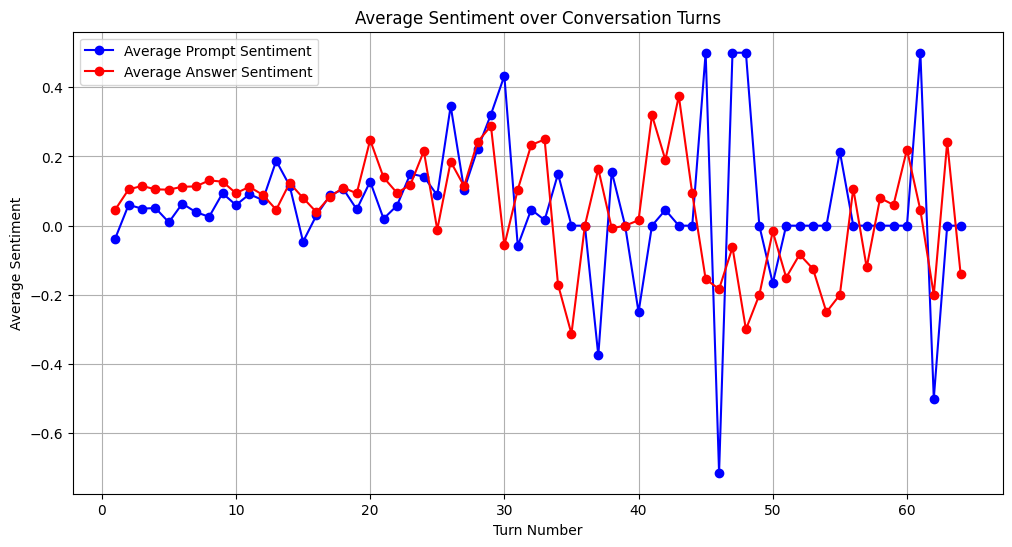

In [30]:
# Plotting the average sentiments over turns
plt.figure(figsize=(12, 6))

plt.plot(turn_positions, avg_prompt_sentiments, marker='o', color='blue', label='Average Prompt Sentiment')
plt.plot(turn_positions, avg_answer_sentiments, marker='o', color='red', label='Average Answer Sentiment')

plt.xlabel('Turn Number')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment over Conversation Turns')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# 3. Statistical Analysis

# Combine prompt and answer sentiments with their turn numbers
# For prompts
prompt_turns = np.array(all_prompt_turns)
prompt_sentiments = np.array(all_prompt_sentiments)

# For answers
answer_turns = np.array(all_answer_turns)
answer_sentiments = np.array(all_answer_sentiments)

# Remove any NaN values (if any)
prompt_mask = ~np.isnan(prompt_sentiments)
answer_mask = ~np.isnan(answer_sentiments)

prompt_turns = prompt_turns[prompt_mask]
prompt_sentiments = prompt_sentiments[prompt_mask]

answer_turns = answer_turns[answer_mask]
answer_sentiments = answer_sentiments[answer_mask]

# Perform Pearson correlation for linear relationship
prompt_pearson_corr, prompt_pearson_p = linregress(prompt_turns, prompt_sentiments)[:2]
answer_pearson_corr, answer_pearson_p = linregress(answer_turns, answer_sentiments)[:2]

# Perform Spearman rank correlation for monotonic relationship
prompt_spearman_corr, prompt_spearman_p = spearmanr(prompt_turns, prompt_sentiments)
answer_spearman_corr, answer_spearman_p = spearmanr(answer_turns, answer_sentiments)

# Print the results
print("Prompt Sentiments:")
print(f"Pearson Correlation Coefficient (for linear relationship): {prompt_pearson_corr:.4f}, p-value: {prompt_pearson_p:.4e}")
print(f"Spearman Correlation Coefficient (for monotonic relationship): {prompt_spearman_corr:.4f}, p-value: {prompt_spearman_p:.4e}\n")

print("Answer Sentiments:")
print(f"Pearson Correlation Coefficient (for linear relationship): {answer_pearson_corr:.4f}, p-value: {answer_pearson_p:.4e}")
print(f"Spearman Correlation Coefficient (for monotonic relationship): {answer_spearman_corr:.4f}, p-value: {answer_spearman_p:.4e}")

Prompt Sentiments:
Pearson Correlation Coefficient (for linear relationship): 0.0031, p-value: 7.3550e-03
Spearman Correlation Coefficient (for monotonic relationship): 0.1834, p-value: 4.8035e-69

Answer Sentiments:
Pearson Correlation Coefficient (for linear relationship): 0.0004, p-value: 8.1751e-02
Spearman Correlation Coefficient (for monotonic relationship): 0.2235, p-value: 1.5767e-102


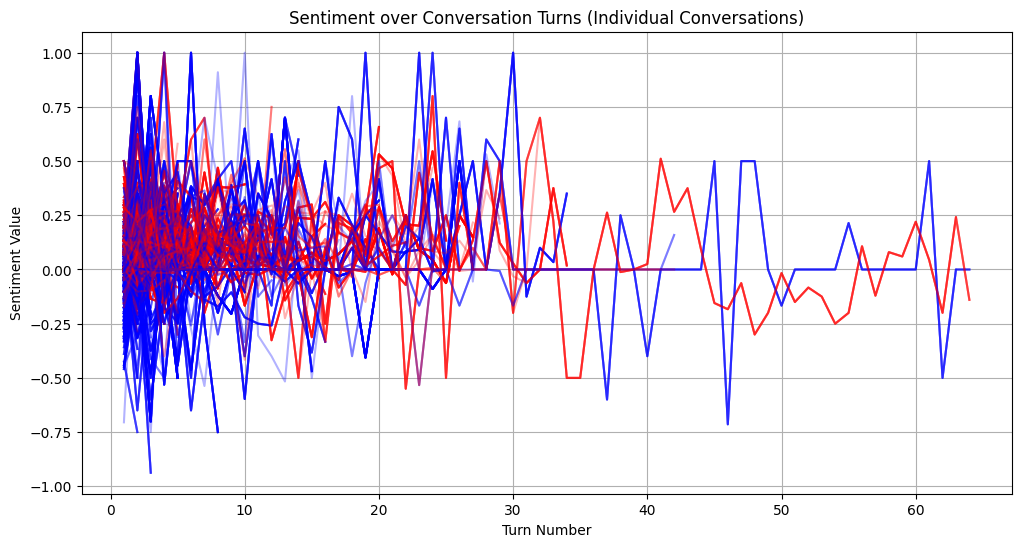

In [32]:
# Plotting individual conversations
plt.figure(figsize=(12, 6))

for conv_idx in range(len(promptsentiments)):
    prompts = promptsentiments[conv_idx]
    answers = answersentiments[conv_idx]
    num_turns = min(len(prompts), len(answers))
    turns = range(1, num_turns + 1)

    # Plot prompts
    plt.plot(
        turns,
        prompts[:num_turns],
        color='blue',
        alpha=0.3,
        #label='Prompt Sentiments'
    )

    # Plot answers
    plt.plot(
        turns,
        answers[:num_turns],
        color='red',
        alpha=0.3,
        #label='Answer Sentiments'
    )

plt.xlabel('Turn Number')
plt.ylabel('Sentiment Value')
#plt.legend()
plt.title('Sentiment over Conversation Turns (Individual Conversations)')
plt.grid(True)
plt.show()

### Part 2: Commit sentiment vs length of conversation

In [33]:
# 1. Compute conversation lengths per commit
convo_length = [
    len(prompts) if prompts else 0 for prompts in promptsentiments
]

In [34]:
convo_length[:5]

[8, 20, 1, 1, 3]

In [35]:
# 1. Perform Pearson correlation (for linear relationship)
pearson_corr_coef, pearson_p_value = linregress(convo_length, commitsentiments)[:2]

# 2. Perform Spearman rank correlation (for monotonic relationship)
spearman_corr_coef, spearman_p_value = spearmanr(convo_length, commitsentiments)

print("Statistical Analysis of Conversation Length vs. Commit Sentiments (for linear relationship):")
print(f"Pearson Correlation Coefficient: {pearson_corr_coef:.4f}, p-value: {pearson_p_value:.4e}")

print("Statistical Analysis of Conversation Length vs. Commit Sentiments (for monotonic relationship):")
print(f"Spearman Correlation Coefficient: {spearman_corr_coef:.4f}, p-value: {spearman_p_value:.4e}")

Statistical Analysis of Conversation Length vs. Commit Sentiments (for linear relationship):
Pearson Correlation Coefficient: 0.0022, p-value: 3.4680e-03
Statistical Analysis of Conversation Length vs. Commit Sentiments (for monotonic relationship):
Spearman Correlation Coefficient: 0.0639, p-value: 2.6812e-04


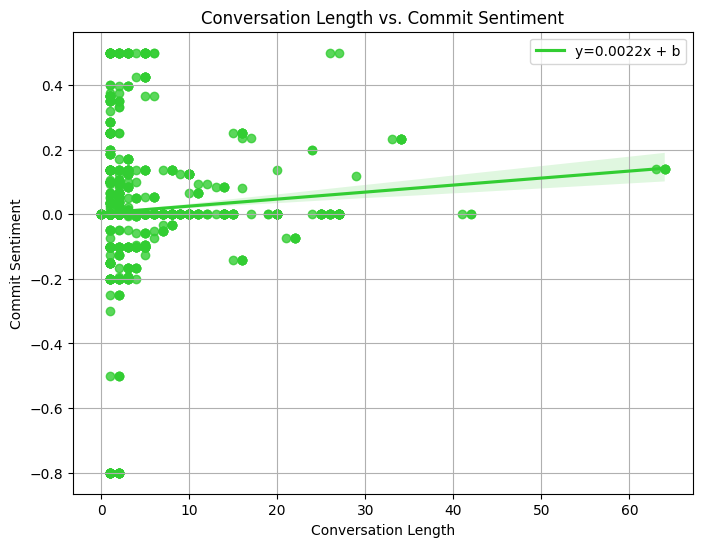

In [36]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x=convo_length,
    y=commitsentiments,
    color='limegreen',
    line_kws={'label': f"y={pearson_corr_coef:.4f}x + b"}
)
plt.xlabel('Conversation Length')
plt.ylabel('Commit Sentiment')
plt.title('Conversation Length vs. Commit Sentiment')
plt.legend()
plt.grid(True)
plt.show()